<a href="https://colab.research.google.com/github/NatnaelTDaba/CAP5610/blob/main/CAP5610_hw2_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

In [1]:
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt 
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
os.chdir('/content/drive/MyDrive/CAP5610/')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(test.shape)
joined_data = pd.concat([train, test], sort = False).reset_index(drop=True)

(418, 11)


## **1. Data Preprocessing**


## A. Feature Construction

### A.1 Preprocess Cabin

In [3]:
missing_cabin = joined_data.Cabin.isna().sum()
print("Number of missing values for Cabin feature:",missing_cabin)

Number of missing values for Cabin feature: 1014


Since cabin has a lot of missing values, we can replaces the NaNs with a single letter placeholder and also take the first letter of the cabin values and use them as the new values in the new feature.

In [4]:
missing_filled = joined_data.Cabin.fillna("X")

In [5]:
joined_data["cabinProcessed"] = missing_filled.str.get(0) 

display(joined_data.cabinProcessed.value_counts())

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabinProcessed, dtype: int64

### A.2 Preprocess Name 

In [6]:
nameTitle = joined_data.Name.str.split(".").str.get(0).str.split(",").str.get(-1)

nameTitle.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True,regex=True)

nameTitle.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True,regex=True)

nameTitle.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True,regex=True)

nameTitle.replace({"the Aristocrat":"Aristocrat"}, inplace = True,regex=True)

joined_data["nameProcessed"] = nameTitle

In [7]:
display(joined_data.nameProcessed.value_counts())

 Mr            757
 Miss          264
 Mrs           198
 Master         61
 Officer        23
 Aristocrat      6
Name: nameProcessed, dtype: int64

### A.3 Preprocess SibSp & Parch 

In [8]:
joined_data["familySize"] = joined_data.SibSp + joined_data.Parch + 1 

display(joined_data.familySize.value_counts())

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: familySize, dtype: int64

In [9]:
joined_data.familySize.replace(to_replace = [1], value = "single", inplace = True)

joined_data.familySize.replace(to_replace = [2,3], value = "small", inplace = True)

joined_data.familySize.replace(to_replace = [4,5], value = "medium", inplace = True)

joined_data.familySize.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)

### A.4 Preprocess Ticket 

In [10]:
otherwise = joined_data.Ticket.str.split(" ").str.get(0).str.get(0) # This extracts the 1st character

joined_data["ticketProcessed"] = np.where(joined_data.Ticket.str.isdigit(), "N", otherwise)

In [11]:
display(joined_data.ticketProcessed.value_counts())

N    957
S     98
P     98
C     77
A     42
W     19
F     13
L      5
Name: ticketProcessed, dtype: int64

## B. Handling Missing Values

### B.1 Imputing Fare & Embarked

In [12]:
joined_data.Embarked.fillna(value="S", inplace = True)

joined_data.Fare.fillna(value=joined_data.Fare.median(), inplace = True)

### B.2 Imputing Age

In [13]:
joined_data.Age = joined_data.groupby(["nameProcessed", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))

display(joined_data.isnull().sum())

PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin              1014
Embarked              0
cabinProcessed        0
nameProcessed         0
familySize            0
ticketProcessed       0
dtype: int64

## C. Data Transformation

### C.1 Banding features

From hw1, we saw that the Age feature had an inverse relationship with Survived and also that infants had a bigger survival rate. Therefore, we can categorize the Age features into serveral bins or age groups to prevent overfitting.

#### *Banding Age*

In [14]:
ageGroups = ["infant","child","teenager","youngAdult","adult","aged"]

groupRanges = [0,5,12,18,35,60,81]

joined_data["ageBinned"] = pd.cut(joined_data.Age, groupRanges, labels = ageGroups)

### *Banding Fare*

Similiarly, we can band the Fare feature which had a positive correlation with the Survived feature.

In [15]:
fareGroups = ["low","medium","high","veryHigh"]

fareGroupRanges = [-1, 130, 260, 390, 520]

joined_data["fareBinned"] = pd.cut(joined_data.Fare, fareGroupRanges, labels = fareGroups)

### C.2 Dropping Redundant and Irrelevant features

Since the following features are not relevant:



*   Age (because it's already binned)
*   Fare (because it's already binned)
*   Cabin (because it's already processed)
*   Ticket (because it's already processed)
*   Name (because it's already processed)

We can remove them from the original DataFrame.



In [16]:
joined_data.drop(columns = ["Name", "Age", "Fare", "Ticket", "Cabin"], inplace = True, axis = 1)

display(joined_data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch',
       'Embarked', 'cabinProcessed', 'nameProcessed', 'familySize',
       'ticketProcessed', 'ageBinned', 'fareBinned'],
      dtype='object')

In [17]:
joined_data

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,cabinProcessed,nameProcessed,familySize,ticketProcessed,ageBinned,fareBinned
0,1,0.0,3,male,1,0,S,X,Mr,small,A,youngAdult,low
1,2,1.0,1,female,1,0,C,C,Mrs,small,P,adult,low
2,3,1.0,3,female,0,0,S,X,Miss,single,S,youngAdult,low
3,4,1.0,1,female,1,0,S,C,Mrs,small,N,youngAdult,low
4,5,0.0,3,male,0,0,S,X,Mr,single,N,youngAdult,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,male,0,0,S,X,Mr,single,A,youngAdult,low
1305,1306,NaN,1,female,0,0,C,C,Aristocrat,single,P,adult,low
1306,1307,NaN,3,male,0,0,S,X,Mr,single,S,adult,low
1307,1308,NaN,3,male,0,0,S,X,Mr,single,N,youngAdult,low


### C.3 Adjusting Data Types

In [21]:
display(joined_data.dtypes)

PassengerId           int64
Survived            float64
Pclass             category
Sex                category
SibSp                 int64
Parch                 int64
Embarked           category
cabinProcessed     category
nameProcessed      category
familySize         category
ticketProcessed    category
ageBinned          category
fareBinned         category
dtype: object

In [22]:
joined_data.loc[:, ["Pclass", "Sex", "Embarked", "cabinProcessed", "nameProcessed", "familySize", "ticketProcessed"]]\
= joined_data.loc[:, ["Pclass", "Sex", "Embarked", "cabinProcessed", "nameProcessed", "familySize", "ticketProcessed"]]\
.astype('category')

In [23]:
display(joined_data.dtypes)

PassengerId           int64
Survived            float64
Pclass             category
Sex                category
SibSp                 int64
Parch                 int64
Embarked           category
cabinProcessed     category
nameProcessed      category
familySize         category
ticketProcessed    category
ageBinned          category
fareBinned         category
dtype: object

### C.4 Feature Encoding

In [24]:
joined_data = pd.get_dummies(joined_data)
display(joined_data.head(2))

,PassengerId,Survived,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabinProcessed_A,cabinProcessed_B,cabinProcessed_C,cabinProcessed_D,cabinProcessed_E,cabinProcessed_F,cabinProcessed_G,cabinProcessed_T,cabinProcessed_X,nameProcessed_ Aristocrat,nameProcessed_ Master,nameProcessed_ Miss,nameProcessed_ Mr,nameProcessed_ Mrs,nameProcessed_ Officer,familySize_large,familySize_medium,familySize_single,familySize_small,ticketProcessed_A,ticketProcessed_C,ticketProcessed_F,ticketProcessed_L,ticketProcessed_N,ticketProcessed_P,ticketProcessed_S,ticketProcessed_W,ageBinned_infant,ageBinned_child,ageBinned_teenager,ageBinned_youngAdult,ageBinned_adult,ageBinned_aged,fareBinned_low,fareBinned_medium,fareBinned_high,fareBinned_veryHigh
0,1,0.0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,2,1.0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0


# **3. Model Building**

In [25]:
train = joined_data.iloc[:891, :]
test  = joined_data.iloc[891:, :]

In [26]:
train = train.drop(columns = ["PassengerId"], axis = 1)
train.Survived = train.Survived.astype(int) 
test = test.drop(columns = ["Survived"], axis = 1) 

In [27]:
xTrain = train.drop(columns = ["Survived"], axis = 1) # Input matrix as pandas dataframe (dim:891*47).
yTrain = train['Survived'] # Output vector as pandas series (dim:891*1)

xTest  = test.drop("PassengerId", axis = 1).copy()

In [28]:
xTrain.shape

(891, 47)

In [29]:
dt = DecisionTreeClassifier(criterion='gini',random_state = 42)

In [30]:
dt.fit(xTrain, yTrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

[Text(861.666055484694, 1055.2235294117647, 'nameProcessed_ Mr <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = died'),
 Text(455.2433035714286, 991.2705882352941, 'Pclass_3 <= 0.5\ngini = 0.422\nsamples = 374\nvalue = [113, 261]\nclass = survived'),
 Text(254.08928571428572, 927.3176470588236, 'nameProcessed_ Officer <= 0.5\ngini = 0.209\nsamples = 202\nvalue = [24, 178]\nclass = survived'),
 Text(200.7091836734694, 863.364705882353, 'nameProcessed_ Aristocrat <= 0.5\ngini = 0.112\nsamples = 184\nvalue = [11, 173]\nclass = survived'),
 Text(150.8877551020408, 799.4117647058824, 'cabinProcessed_C <= 0.5\ngini = 0.096\nsamples = 179\nvalue = [9, 170]\nclass = survived'),
 Text(85.40816326530613, 735.4588235294118, 'Pclass_2 <= 0.5\ngini = 0.076\nsamples = 151\nvalue = [6, 145]\nclass = survived'),
 Text(74.02040816326532, 671.5058823529412, 'gini = 0.0\nsamples = 66\nvalue = [0, 66]\nclass = survived'),
 Text(96.79591836734694, 671.5058823529412, 'ageBinned_adult <= 0.5\

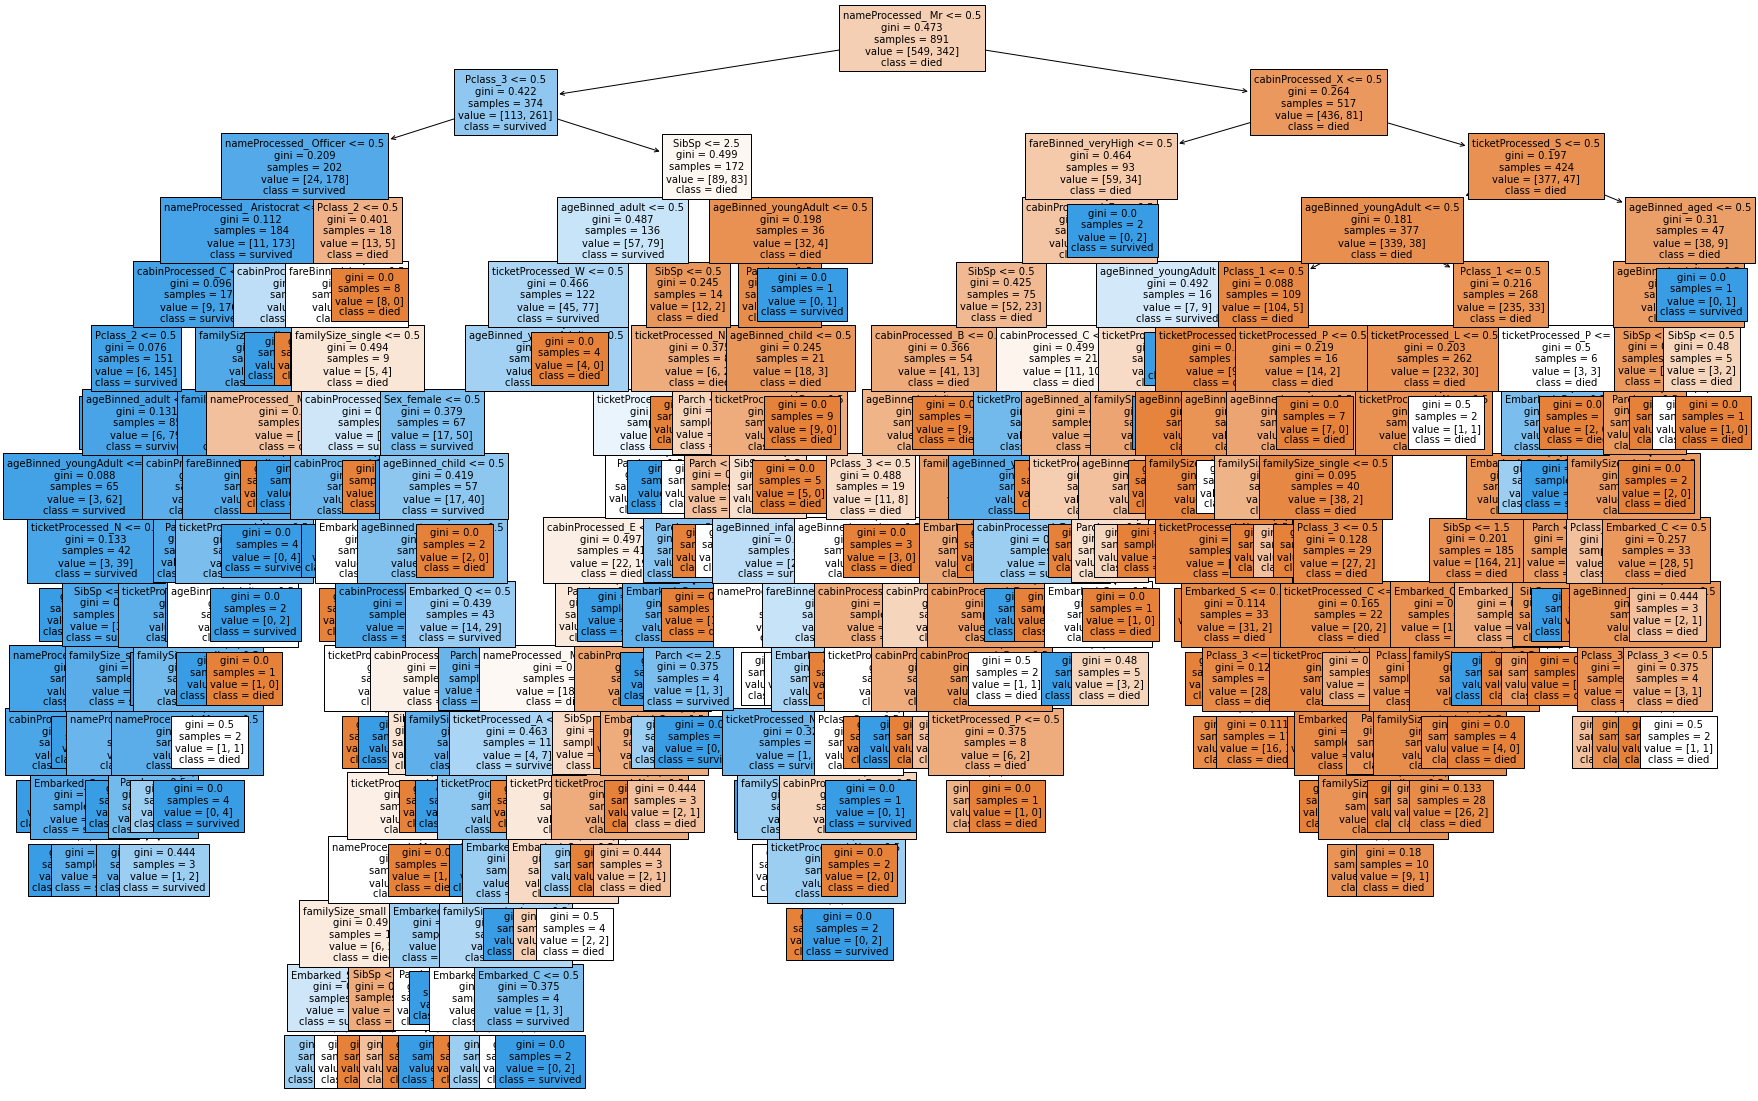

In [31]:
plt.figure(figsize=(30,20))  
feature_names = list(xTrain.columns)
class_names = ['died','survived']
tree.plot_tree(dt, fontsize=10, filled=True,feature_names=feature_names, class_names=class_names)

# **4. Cross Validation of Decision Tree**


In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
xValScore = cross_val_score(dt, xTrain, yTrain, cv = 5, scoring="accuracy").mean()
xValScore = round(xValScore*100, 2)
print("Average classification accuracy of the trained decision tree:",xValScore)

Average classification accuracy of the trained decision tree: 79.02


# Cross Validation of Random Forest

In [34]:
rf = RandomForestClassifier(n_estimators = 120, random_state=42)
xValScore = cross_val_score(rf, xTrain, yTrain, cv = 5, scoring="accuracy").mean()
xValScore = round(xValScore*100, 2)
print("Average classification accuracy of the trained random forest:",xValScore)

Average classification accuracy of the trained random forest: 79.58
